<a href="https://colab.research.google.com/github/mkierczak/autoencoders_workshop/blob/main/PCA2VAE_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we will download and upack data accompanying article by Lazaridis et. al. [*Genomic insights into the origin of farming in the ancient Near East*](https://www.nature.com/articles/nature19310) 2016. Nature **536**:419-424.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

In [1]:
!wget -O data_hd5 https://www.dropbox.com/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.hd5?rlkey=xp4nfljz0c2za9ihriletxx3x&dl=0

--2023-09-01 11:02:54--  https://www.dropbox.com/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.hd5?rlkey=xp4nfljz0c2za9ihriletxx3x
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.hd5?rlkey=xp4nfljz0c2za9ihriletxx3x [following]
--2023-09-01 11:02:54--  https://www.dropbox.com/e/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.hd5?rlkey=xp4nfljz0c2za9ihriletxx3x
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccf366adfaa53e80cc43ba93e50.dl.dropboxusercontent.com/cd/0/inline/CC6vmH2EYD9q210-t5ErlsblUkyNwq7yJuafnfL1wjFbtixGFR8qu1oE_XxbX77HXcR--wQePgxXbt7tNeRZbvNKRSMR0sLz1AFOmSoR9pNm9aFTMYR-nYN_e9ECp52YJxA/file# [following]
--2

In [7]:
orig_gt = pd.read_hdf('./data_hd5', key = 'geno')
orig_pheno = pd.read_hdf('./data_hd5', key = 'pheno')
orig_snp = pd.read_hdf('./data_hd5', key = 'snps')


In [26]:
print(orig_gt.info())
print(orig_gt.iloc[0:4, 0:4])
print(orig_pheno.iloc[0:4, ])
print(orig_snp.iloc[0:4, ])

<class 'pandas.core.frame.DataFrame'>
Index: 2068 entries, SA1004 to G434
Columns: 48433 entries, rs7419119 to rs10788875
dtypes: float64(48433)
memory usage: 764.2+ MB
None
        rs7419119  rs13302957  rs6696609  rs8997
SA1004        2.0         0.0        1.0     2.0
SA063         0.0         2.0        1.0     1.0
SA010         2.0         1.0        0.0     1.0
SA064         2.0         1.0        1.0     1.0
       id gender      pop
0  SA1004      F  Khomani
1   SA063      F  Khomani
2   SA010      F  Khomani
3   SA064      M  Khomani
          SNP CHR        cm       POS A1 A2
0   rs7419119   1  0.022518  842013.0  T  G
1  rs13302957   1  0.024116  891021.0  G  A
2   rs6696609   1  0.024457  903426.0  C  T
3      rs8997   1  0.025727  949654.0  A  G


In [30]:
print("Missing genotypes per marker: \n", orig_gt.isna().sum())

Missing genotypes per marker: 
 rs7419119      4
rs13302957     3
rs6696609     14
rs8997        10
rs9442372      5
              ..
rs6683472      6
rs4926509     10
rs11205415     7
rs4072273      4
rs10788875     5
Length: 48433, dtype: int64


In [31]:
geno = orig_gt.replace([0, 1.0, 2.0], [0.5, 0.75, 1.0])
geno.fillna(0, inplace = True)
print(geno.isna().sum())
print(geno.iloc[0:5, 0:5])


rs7419119     0
rs13302957    0
rs6696609     0
rs8997        0
rs9442372     0
             ..
rs6683472     0
rs4926509     0
rs11205415    0
rs4072273     0
rs10788875    0
Length: 48433, dtype: int64
        rs7419119  rs13302957  rs6696609  rs8997  rs9442372
SA1004       1.00        0.50       0.75    1.00       0.50
SA063        0.50        1.00       0.75    0.75       0.75
SA010        1.00        0.75       0.50    0.75       0.50
SA064        1.00        0.75       0.75    0.75       0.75
SA073        0.75        0.50       0.75    0.75       0.50


In [58]:
train = geno.sample(frac = 0.8, random_state = 42)
test = geno.drop(train.index)
pheno = orig_pheno.set_index(keys = 'id')
train_pheno = pheno[pheno.index.isin(train.index)]
test_pheno = pheno.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# Print some info about the resulting split
print("Original data:", orig_gt.shape)
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Original data: (2068, 48433)
	 - training set: (1654, 48433)
	 - test set: (414, 48433)


In [67]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(orig_gt) * 2

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: ignored

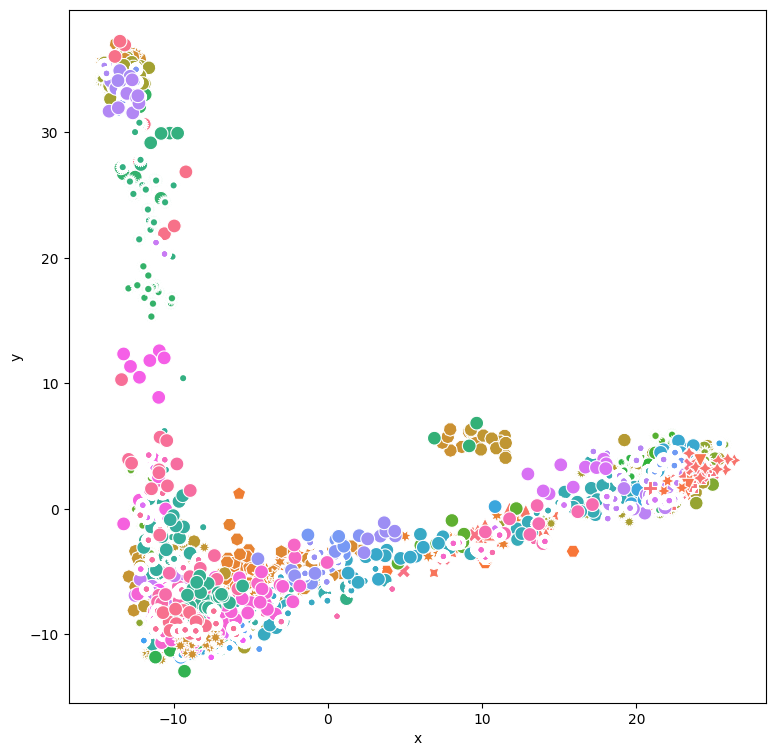

In [75]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno) * 2
x = pca_embedding[:,0]
y = pca_embedding[:,1]
pop = pheno.iloc[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (9,9))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=False)
plt.show()

In [77]:
#geno_imputed = orig_gt.fillna(orig_gt.mode().iloc[0])
#embedding = PCA(n_components=2)
#pca_embedding = embedding.fit_transform(geno_imputed) * 2
#x = pca_embedding[:,0]
#y = pca_embedding[:,1]
#pop = pheno.iloc[:,1]
#data = {'x':x, 'y':y, 'pop':pop}
#plt.figure(figsize = (9,9))
#sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=False)
#plt.show()

In [78]:
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2
print(type(train_tensor))

<class 'numpy.ndarray'>


In [82]:
# Encoder
input = keras.Input(shape = (original_dim,))
output = input

def Encoder_core(input):
  h = layers.Dense(units = 1000, activation = 'relu')(input)
  h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 100, activation = 'relu')(h)
  h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 25, activation = 'relu')(h)
  h = layers.BatchNormalization()(h)
  return(h)

def Bottleneck_vanilla(h, latent_dim):
  h = layers.Dense(units = latent_dim, name='layer_bottleneck')(h)
  return(h)

def Decoder(bottleneck, original_dim):
  h = layers.Dense(units = 25, activation = 'relu')(bottleneck)
  h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 100, activation = 'relu')(h)
  h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 1000, activation = 'relu')(h)
  h = layers.BatchNormalization()(h)
  h = layers.Dense(original_dim, activation='sigmoid')(h)
  return(h)

def Autoencoder(input, latent_dim, original_dim):
  encoder = Bottleneck_vanilla(Encoder_core(input), latent_dim)
  autoencoder = Decoder(encoder, original_dim)
  return(autoencoder)

ae_model = keras.Model(inputs = input, outputs = Autoencoder(input, latent_dim, original_dim))

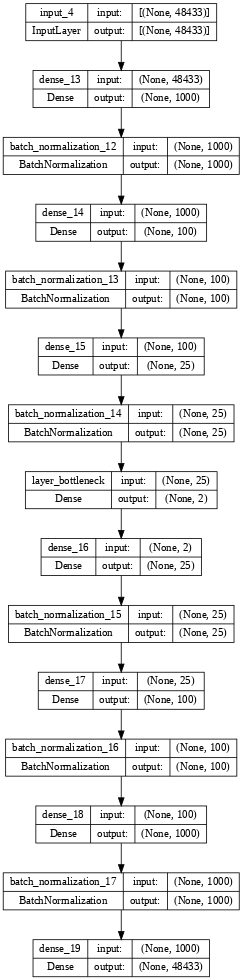

In [95]:
plot_model(ae_model, show_shapes=True, show_layer_names = True, dpi=58, to_file="model.png")

In [97]:
hp_loss_fn = 'mse'
hp_optimizer = 'adam'
hp_metrics = ['mse','mae','mape']

ae_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)
ae_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48433)]           0         
                                                                 
 dense_13 (Dense)            (None, 1000)              48434000  
                                                                 
 batch_normalization_12 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 100)               100100    
                                                                 
 batch_normalization_13 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 25)                2525

In [99]:
hp_epochs = 30
hp_batch_size = 256
hp_val_split = 0.2

autoencoder = ae_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
6/6 [==============================] - 34s 5s/step - loss: 0.1726 - mse: 0.1726 - mae: 0.3750 - mape: 1117704.2500 - val_loss: 0.1794 - val_mse: 0.1794 - val_mae: 0.3825 - val_mape: 1032181.5625
Epoch 2/30
6/6 [==============================] - 28s 5s/step - loss: 0.1692 - mse: 0.1692 - mae: 0.3734 - mape: 1106518.8750 - val_loss: 0.1998 - val_mse: 0.1998 - val_mae: 0.4038 - val_mape: 1001532.8125
Epoch 3/30
6/6 [==============================] - 29s 5s/step - loss: 0.1676 - mse: 0.1676 - mae: 0.3715 - mape: 1101702.6250 - val_loss: 0.2206 - val_mse: 0.2206 - val_mae: 0.4223 - val_mape: 950986.4375
Epoch 4/30
6/6 [==============================] - 27s 5s/step - loss: 0.1651 - mse: 0.1651 - mae: 0.3671 - mape: 1105366.1250 - val_loss: 0.2376 - val_mse: 0.2376 - val_mae: 0.4337 - val_mape: 925568.5625
Epoch 5/30
6/6 [==============================] - 28s 5s/step - loss: 0.1608 - mse: 0.1608 - mae: 0.3613 - mape: 1117331.1250 - val_loss: 0.2493 - val_mse: 0.2493 - val_mae: 0.44

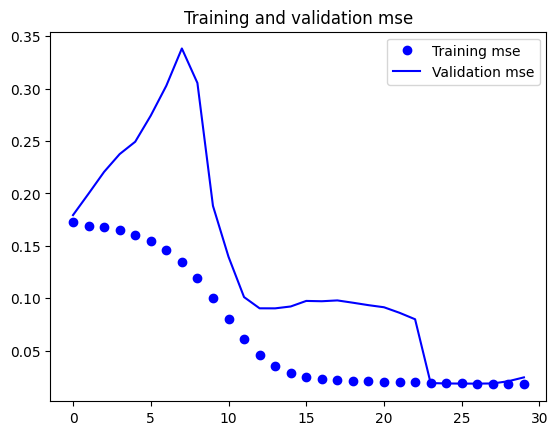

In [103]:
loss = autoencoder.history['loss']
mse = autoencoder.history['mse']
val_loss = autoencoder.history['val_loss']
val_mse = autoencoder.history['val_mse']
epochs = range(hp_epochs)
plt.figure()
#plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.show()

In [108]:
geno_tensor = geno.to_numpy()
geno_dim = geno_tensor.shape[1]
input = keras.Input(shape = (geno_dim,))

ae_model.save_weights('autoencoder_weights.h5',
                               overwrite = True)

trained_model = keras.Model(inputs = input, outputs = Autoencoder(input, latent_dim, geno_dim))
trained_model.load_weights('autoencoder_weights.h5',
                           skip_mismatch = True,
                           by_name = True)
trained_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)